# K-Means and Gaussian Mixture Models

## Proposed Method

We will first use the k-means clustering algorithm to produce the mean values that we will use to initialize our GMMs, followed by Expectation Maximization to calculate the covariances of the GMMs.

## Step 0: Data Preparation and Exploration

After importing our basic utility libraries and dataset, we plot our data to get an understanding of what kind of models we should be working with. 

We will first work with the Synthetic data.

In [18]:
import numpy as np
import matplotlib.pyplot as plt

train_data = np.loadtxt("Synthetic/29/train.txt",delimiter=",")
train_data_classes = np.asarray([train_data[np.where(train_data[:,2]==i)] for i in [1,2]])

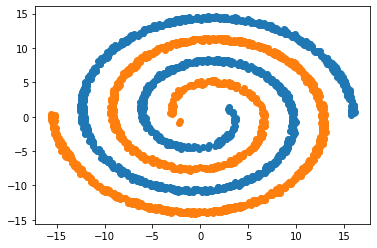

In [4]:
plt.scatter(train_data_classes[0,:,0],train_data_classes[0,:,1])
plt.scatter(train_data_classes[1,:,0],train_data_classes[1,:,1])
plt.show()

As we can clearly see above, using k-means clustering on this dataset with 2 clusters will yield disastrous results.

Hence, we will instead use k-means to initialize our mean positions and then utilize them to generate GMMs.

## Step 1: Implementing $k$-means clustering

This step is slightly complex, so reading through the comments will be more useful to follow along.

We essentially make use of numpy broadcasting and indexing to vectorize our entire operation which speeds it up tremendously. 

Vectorization enables our code to be generalized to work with any $d$ dimensional dataset, with any choice of $k$, and any dataset size $n$. The only thing required is for each data example to be provided in the form `[x1, x2, x3, ... xn, class]`

In [10]:
def k_means(data,k=15):
    # reshape data for numpy broadcasting
    data = np.reshape(data,[-1,1,data.shape[-1]])
    # initialize k means with random means
    myrange = np.linspace(0,data.shape[0]-1,k,dtype = np.int64)
    kmeans = np.vstack([data[myrange,0,i] for i in range(0,data.shape[-1])]).T
    # reshape data for numpy broadcasting
    kmeans = np.reshape(kmeans,[1,-1,kmeans.shape[-1]])
    # calculate distances with some broadcasting magic
    dists = np.sum((data - kmeans)**2,axis=2)
    # initialize cluster assignments
    
    # choose n rows from a kxk identity matrix 
    # using an nx1 argmin matrix (ranging from 0 to k-1)
    # to produce an nxk 1-hot encoded matrix
    r_nk_old = np.eye(k)[np.argmin(dists,axis=1)]
    r_nk_new = r_nk_old.copy()
    c = 0
    while True:
        #print(f"Iteration {c}")
        c+=1
        # move cluster assignments into old variable for comparison
        r_nk_old = r_nk_new.copy()
        # update means
        if np.any(np.sum(r_nk_old,axis=0) == 0):
            print(r_nk_old)
            print("error, 0 sum encountered")
            break
        kmeans = (r_nk_old.T @ np.squeeze(data))/np.reshape(np.sum(r_nk_old,axis=0),[-1,1])
        # update new cluster assignments
        dists = np.sum((data - kmeans)**2,axis=2)
        r_nk_new = np.eye(k)[np.argmin(dists,axis=1)]
        # test for convergence
        if np.all(r_nk_old == r_nk_new):
            break
    print(f"Iterations to convergence = {c}")
    return kmeans, r_nk_new

Now we will see what kind of means we have got from this, and whether we should use more or less complex values of $k$.

Iterations to convergence = 52
Iterations to convergence = 35


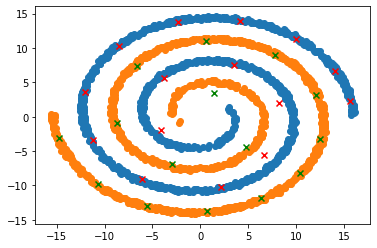

In [16]:
means0,allotments0 = k_means(train_data_classes[0,:,:])
means1,allotments1 = k_means(train_data_classes[1,:,:])
plt.scatter(train_data_classes[0,:,0],train_data_classes[0,:,1])
plt.scatter(train_data_classes[1,:,0],train_data_classes[1,:,1])
plt.scatter(means0[:,0],means0[:,1],c='r',marker='x')
plt.scatter(means1[:,0],means1[:,1],c='g',marker='x')
plt.show()

## What happens when we use other values of $k$

### Larger values of $k$

This is expected to be more accurate and closely fit the data, but will make our GMM covariance calculation step extremely lengthy.

Iterations to convergence = 25
Iterations to convergence = 17


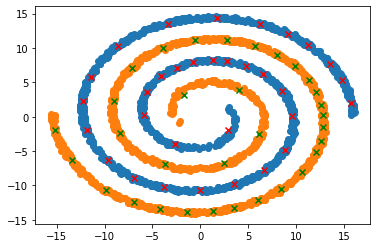

In [15]:
# larger k values:

means0,allotments0 = k_means(train_data_classes[0,:,:],32)
means1,allotments1 = k_means(train_data_classes[1,:,:],32)
plt.scatter(train_data_classes[0,:,0],train_data_classes[0,:,1])
plt.scatter(train_data_classes[1,:,0],train_data_classes[1,:,1])
plt.scatter(means0[:,0],means0[:,1],c='r',marker='x')
plt.scatter(means1[:,0],means1[:,1],c='g',marker='x')
plt.show()

As seen above, too large a value of $k$, while being extremely accurate, is not necessary as there are too many cluster centers in a very small region, which is unnecessary and will slow us down tremendously while calculating the GMM covariances.

### Smaller values of $k$

This is expected to too inaccurate to fit the data, and may actually yield worse performance than baseline (<50%) but will make our GMM covariance calculation step much faster.

Iterations to convergence = 23
Iterations to convergence = 39


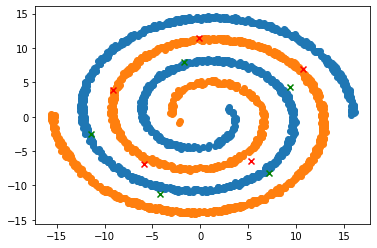

In [17]:
# smaller k values:

means0,allotments0 = k_means(train_data_classes[0,:,:],5)
means1,allotments1 = k_means(train_data_classes[1,:,:],5)
plt.scatter(train_data_classes[0,:,0],train_data_classes[0,:,1])
plt.scatter(train_data_classes[1,:,0],train_data_classes[1,:,1])
plt.scatter(means0[:,0],means0[:,1],c='r',marker='x')
plt.scatter(means1[:,0],means1[:,1],c='g',marker='x')
plt.show()

As clearly seen above, the cluster centers for too small a value of $k$ leads to the means being in the totally opposite distribution, which would actually give us worse performance than a baseline of 50%